---
## Step 0: Load The Data

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import os
import pickle
import copy
from PIL import Image
from skimage import exposure

In [2]:
# TODO: Fill this in based on where you saved the training and testing data
filePath = 'traffic-signs-data/'
training_file = filePath+'train.p'
validation_file= filePath+'valid.p'
testing_file = filePath+'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration
### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
labels = pd.read_csv('signnames.csv')
n_classes = len(labels)

print("Number of training examples: x={0}, y={1}".format(n_train, y_train.shape[0]))
print("Number of validation examples: x={0}, y={1}".format(n_validation, y_valid.shape[0]))
print("Number of testing examples:  x={0}, y={1}".format(n_test, y_test.shape[0]))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples: x=34799, y=34799
Number of validation examples: x=4410, y=4410
Number of testing examples:  x=12630, y=12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [4]:
%%time
y_train_df = pd.DataFrame(data=y_train, columns=['ClassId'])
y_valid_df = pd.DataFrame(data=y_valid, columns=['ClassId'])
y_test_df = pd.DataFrame(data=y_test, columns=['ClassId'])

grouped_train_index = y_train_df.groupby('ClassId')
grouped_valid_index = y_valid_df.groupby('ClassId')
grouped_test_index = y_test_df.groupby('ClassId')

## Get the first index images in each class
firstTrainDataForEachClass = grouped_train_index.head(1).sort_values('ClassId').reset_index()
#print(firstTrainDataForEachClass)

Wall time: 5 ms


----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (Self: normalization, grayscale, etc.)
### 1. Grayscale: OpenCV, 2. Normalization: OpenCV, 3. Enhance Contrast: OpenCV, 4. so on

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

## Change to gray scale
def colourToGrey(images):
    # X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    gray = np.zeros([len(images), 32, 32], dtype=np.uint8)
    for idx in tqdm(range(len(images))):
        gray[idx] = cv2.cvtColor(images[idx], cv2.COLOR_RGB2GRAY)
    return gray

## Normalisation
def normaliseColourImages(images):
    images = images.astype(np.float32)
    for idx, img in tqdm(enumerate(images)):
        images[idx] = cv2.normalize(img, dst=img, alpha=0, beta=0.999999, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return images

## Enhance Contrast using histogram equalization
def enhanceContrastOfImage(img):
    return cv2.equalizeHist(img)
    '''
    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv_img[:,:,0] = cv2.equalizeHist(yuv_img[:,:,0])
    return cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)
    '''
    '''
    if np.mean(img) < 50:
        brightImage = img.copy()
        brightImage[:,:,0] = cv2.equalizeHist(img[:,:,0])
        brightImage[:,:,1] = cv2.equalizeHist(img[:,:,1])
        brightImage[:,:,2] = cv2.equalizeHist(img[:,:,2])
        return brightImage
    return img
    '''


def sharpenImage(img):
    kernelOfSharpener = np.array([[-1,-1,-1,-1,-1], 
                                 [-1,2,2,2,-1], 
                                 [-1,2,8,2,-1],
                                 [-1,2,2,2,-1],
                                 [-1,-1,-1,-1,-1]]) / 8.0
    return cv2.filter2D(img, -1, kernelOfSharpener)

def affineTransformation(img):
    row, column = X_train[8000].shape[:2]
    sourcePoints = np.float32([[0, 0], [column-1, 0], [0, row-1]])

    destinationPoints = np.float32([[np.random.uniform(low=0., high=0.2, size=1)[0]*(row-1), np.random.uniform(low=0., high=0.2, size=1)[0]*(column-1)], 
                                    [np.random.uniform(low=0.7, high=1, size=1)[0]*(row-1), np.random.uniform(low=0., high=0.2, size=1)[0]*(column-1)], 
                                    [np.random.uniform(low=0., high=0.2, size=1)[0]*(row-1), np.random.uniform(low=0.7, high=1, size=1)[0]*(column-1)]])

    affine_matrix = cv2.getAffineTransform(sourcePoints, destinationPoints)
    #img_output = cv2.warpAffine(X_train[8000], affine_matrix, (row, column))
    
    return cv2.warpAffine(img, affine_matrix, (row, column))

def translateImageWithRandomDistance(img):
    row, column = img.shape[:2]
    matrixForTranslation = np.array([ [1, 0, np.random.randint(low=-5, high=5)], [0, 1, np.random.randint(low=-5, high=5)] ], dtype=float)
    translatedImage = cv2.warpAffine(img, matrixForTranslation, (row, column))
    return translatedImage

def rotateImageWithRandomAngle(img):
    row, column = img.shape[:2]
    matrixForRotation = cv2.getRotationMatrix2D((column/2, row/2), np.random.randint(low=-35, high=35), 1)
    rotatedImage = cv2.warpAffine(img, matrixForRotation, (row, column))
    return rotatedImage

def makeBallanceBetweenClasses(grouped_y_index=None, xData=None, yData=None):
    ## balance the number of samples in classes
    maxSampleNumbersAmongClasses = max(grouped_y_index.size())
    argmaxSampleNumbersAmongClasses = np.argmax(grouped_y_index.size())

    for class_idx, value in tqdm(grouped_y_index.groups.items()):
        '''
        if class_idx>1:
            break
        '''
        necessaryNum = maxSampleNumbersAmongClasses - len(value)
        randomImgInAClass = xData[np.random.choice(grouped_y_index.groups[class_idx].values, necessaryNum)]

        augmented_y = np.ones(necessaryNum) * class_idx

        for idx, img in enumerate(randomImgInAClass):
            randomImgInAClass[idx] = transAndRotate(img)
            #randomImgInAClass[idx] = transAndRotate(colourToGrey(img))
        xData = np.vstack([xData, randomImgInAClass])
        yData = np.append(yData, augmented_y)
        
    return xData, yData

def transAndRotate(img):
    switch = np.random.choice(('affine', 'rotate', 'translate', 'rotate+translate'), size=1)[0] # choose one among three strings
    #print(switch)
    if switch == 'affine':
        return affineTransformation(img)
    if switch == 'rotate':
        return rotateImageWithRandomAngle(img)
    if switch == 'translate':
        return translateImageWithRandomDistance(img)
    if switch == 'rotate+translate':
        return translateImageWithRandomDistance(img)

In [6]:
def saveToPickle(data, file_name=None, folder_path=None):
    if not os.path.isdir(folder_path):
        #print("Create \"preprocessed-data\" folder")
        os.mkdir(folder_path)
    else:
        print("\"preprocessed-data\" folder already exist")

    file_name = folder_path + file_name
    if not os.path.exists(file_name):
        try:
            with open(file_name, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
                print("Create", file_name)
        except Exception as e:
            print('Error: unable to save data to', file_name, 'because', e)
            
def loadPickle(file_name=None, folder_path=None):
    file = folder_path + file_name
    #print('Load')
    if os.path.exists(file):
        try:
            with open(file, 'rb') as f:
                return pickle.load(f)
                print("Open", file)
        except Exception as e:
            print('Error: unable to open data to', file, 'because', e)

#### Colour to Gray

In [7]:
# colour to gray
augmented_X_train = colourToGrey(X_train)
augmented_X_valid = colourToGrey(X_valid)
augmented_X_test = colourToGrey(X_test)

100%|████████████████████████████████| 12630/12630 [00:00<00:00, 246439.12it/s]


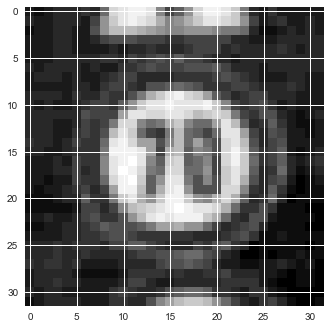

In [8]:
plt.imshow(augmented_X_train[7809], cmap='gray')

#### Normalisation

In [9]:
# normalisation
augmented_X_train = normaliseColourImages(augmented_X_train)
augmented_X_valid = normaliseColourImages(augmented_X_valid)
augmented_X_test = normaliseColourImages(augmented_X_test)

34799it [00:00, 289991.37it/s]
4410it [00:00, 271382.39it/s]
12630it [00:00, 297176.34it/s]


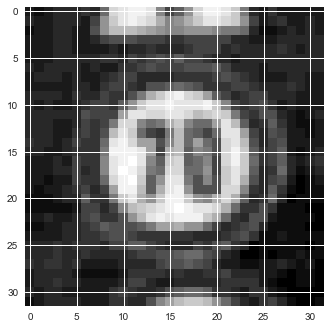

In [10]:
plt.imshow(augmented_X_train[7809], cmap='gray')

#### Augmentation and Transformation

In [11]:
augmented_X_train, augmented_y_train = makeBallanceBetweenClasses(grouped_train_index, augmented_X_train, y_train)
augmented_X_valid, augmented_y_valid = makeBallanceBetweenClasses(grouped_valid_index, augmented_X_valid, y_valid)
augmented_X_test, augmented_y_test = makeBallanceBetweenClasses(grouped_test_index, augmented_X_test, y_test)

100%|██████████████████████████████████████████| 43/43 [00:02<00:00, 14.05it/s]


In [12]:
saveToPickle(augmented_X_train, file_name='augmented_X_train.p', folder_path="./preprocessed-data/")
saveToPickle(augmented_y_train, file_name='augmented_y_train.p', folder_path="./preprocessed-data/")

saveToPickle(augmented_X_valid, file_name='augmented_X_valid.p', folder_path="./preprocessed-data/")
saveToPickle(augmented_y_valid, file_name='augmented_y_valid.p', folder_path="./preprocessed-data/")

saveToPickle(augmented_X_test, file_name='augmented_X_test.p', folder_path="./preprocessed-data/")
saveToPickle(augmented_y_test, file_name='augmented_y_test.p', folder_path="./preprocessed-data/")

"preprocessed-data" folder already exist
Create ./preprocessed-data/augmented_X_train.p
"preprocessed-data" folder already exist
Create ./preprocessed-data/augmented_y_train.p
"preprocessed-data" folder already exist
Create ./preprocessed-data/augmented_X_valid.p
"preprocessed-data" folder already exist
Create ./preprocessed-data/augmented_y_valid.p
"preprocessed-data" folder already exist
Create ./preprocessed-data/augmented_X_test.p
"preprocessed-data" folder already exist
Create ./preprocessed-data/augmented_y_test.p


In [13]:
np.shape(augmented_X_train)

(86430, 32, 32)

#### Load Data